## TODO
- Consider these columns comparing with -1M and -2M:
    > num_25, num_50, num_75, num_985, num_100, num_unq

- Remove these columns:
    - is_cancel
    - is_active
    - payment_plan_days

- Data prep:
    - Left join users table
        - If the user information is none, copy info from last / next available month!

In [31]:
%load_ext autoreload
%autoreload 2

In [1]:
from Utils.DataLoader import DataLoader
from Utils.DataTransformer import DataTransformer
from Utils.DuckDb import DuckDb
from datetime import datetime
import pandas as pd
from typing import List
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from Utils import PandasNotebookConfigs

# Importing all the tools we need

# Regular EDA (Exploratory Data Analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# If matplotlib plots don't work, uncomment this line
# %matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

/home/caio/Git-Projetos/2025-case-data-master-caio-arrabal/env/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 9.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
PandasNotebookConfigs.config()

Ajustando display.float.format para %.4f


In [3]:
DUCK_DB_UTILS = DuckDb()
DATA_TRANSFORMER = DataTransformer()

In [4]:
TABLE_NAME = 'treated_churn_dataset_2025_03_13_15h03m' # Best Dataset - 14/03/2025
TABLE_NAME = 'treated_churn_dataset_2025_03_15_08h55m' # Last processed dataset after changes on 14/03/2025
TABLE_NAME = 'treated_churn_dataset_2025_03_16_12h04m' # Last processed dataset to test after churn logic change (16/03/2025)

In [5]:
df = DUCK_DB_UTILS.load_table(TABLE_NAME, limit = 700_000)

In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
df = df[:1_000_000]

In [8]:
len(df)

700000

In [9]:
# Treating DF
df.isna().sum().T

cost                                       0
msno                                       0
safra                                      0
num_25                                     0
num_50                                     0
num_75                                     0
num_985                                    0
num_100                                    0
num_unq                                    0
total_secs                                 0
total_hours                                0
msno_1                                     0
payment_method_id                          0
payment_plan_days                          0
plan_list_price                            0
actual_amount_paid                         0
is_auto_renew                              0
is_cancel                                  0
safra_1                                    0
transaction_date_year                      0
transaction_date_month                     0
transaction_date_day                       0
transactio

In [10]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,...,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M
0,51.4572,31zhxZ75IMn6yvx+6vVZewvfvBQ06PrQbD3uCnpj/dE=,201607,10,5,0,3,40,47,12175,...,10.0000,16.0000,1.0000,6.0000,2.0000,3.0000,1.0000,8.0000,15.0000,46.0000
1,89.2987,3BXBDSs/vVZOmR5g5LjdCFUhHHmEkSH5zqr2ALeLuwI=,201608,167,45,28,23,1355,1240,329747,...,168.0000,110.0000,92.0000,54.0000,38.0000,22.0000,21.0000,18.0000,1197.0000,1135.0000
2,50.0133,0etfCxti8YIbXvWpS/o3Nzzo5KE3Rg+Y2uby7J1/T5c=,201611,2,0,0,0,0,2,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,61.1830,/oWWTq2tcKk45Yp8hFw9ZXjUBF39BEFAnLgXAPwKaqw=,201611,214,18,10,10,325,483,87197,...,242.0000,150.0000,18.0000,15.0000,6.0000,9.0000,7.0000,5.0000,275.0000,233.0000
4,52.9309,+dh+R4kWdb6Nv3r1mavCoPXCblWU6zoitaOTDQouSp4=,201611,55,8,1,2,101,88,24821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
len(df)

700000

In [12]:
# Feature engineering
df['safra_year'] = df['safra'].astype(str).str[:4].astype(float)
df['safra_month'] = df['safra'].astype(str).str[-2:].astype(float)
df = df.drop('safra', axis=1)

In [13]:
df.head()

,cost,msno,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,...,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,safra_year,safra_month
0,51.4572,31zhxZ75IMn6yvx+6vVZewvfvBQ06PrQbD3uCnpj/dE=,10,5,0,3,40,47,12175,3.3819,...,1.0000,6.0000,2.0000,3.0000,1.0000,8.0000,15.0000,46.0000,2016.0000,7.0000
1,89.2987,3BXBDSs/vVZOmR5g5LjdCFUhHHmEkSH5zqr2ALeLuwI=,167,45,28,23,1355,1240,329747,91.5964,...,92.0000,54.0000,38.0000,22.0000,21.0000,18.0000,1197.0000,1135.0000,2016.0000,8.0000
2,50.0133,0etfCxti8YIbXvWpS/o3Nzzo5KE3Rg+Y2uby7J1/T5c=,2,0,0,0,0,2,31,0.0086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016.0000,11.0000
3,61.1830,/oWWTq2tcKk45Yp8hFw9ZXjUBF39BEFAnLgXAPwKaqw=,214,18,10,10,325,483,87197,24.2214,...,18.0000,15.0000,6.0000,9.0000,7.0000,5.0000,275.0000,233.0000,2016.0000,11.0000
4,52.9309,+dh+R4kWdb6Nv3r1mavCoPXCblWU6zoitaOTDQouSp4=,55,8,1,2,101,88,24821,6.8947,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016.0000,11.0000


In [14]:
df.isna().sum().T

cost                                       0
msno                                       0
num_25                                     0
num_50                                     0
num_75                                     0
num_985                                    0
num_100                                    0
num_unq                                    0
total_secs                                 0
total_hours                                0
msno_1                                     0
payment_method_id                          0
payment_plan_days                          0
plan_list_price                            0
actual_amount_paid                         0
is_auto_renew                              0
is_cancel                                  0
safra_1                                    0
transaction_date_year                      0
transaction_date_month                     0
transaction_date_day                       0
transaction_date_day_of_week               0
transactio

In [15]:
list(df.columns)

['cost',
 'msno',
 'num_25',
 'num_50',
 'num_75',
 'num_985',
 'num_100',
 'num_unq',
 'total_secs',
 'total_hours',
 'msno_1',
 'payment_method_id',
 'payment_plan_days',
 'plan_list_price',
 'actual_amount_paid',
 'is_auto_renew',
 'is_cancel',
 'safra_1',
 'transaction_date_year',
 'transaction_date_month',
 'transaction_date_day',
 'transaction_date_day_of_week',
 'transaction_date_day_of_year',
 'membership_expire_date_year',
 'membership_expire_date_month',
 'membership_expire_date_day',
 'membership_expire_date_day_of_week',
 'membership_expire_date_day_of_year',
 'discount',
 'price_per_month',
 'members_msno',
 'members_safra',
 'city',
 'registered_via',
 'is_active',
 'registration_init_time_year',
 'registration_init_time_month',
 'registration_init_time_day',
 'registration_init_time_day_of_week',
 'registration_init_time_day_of_year',
 '_filled_out_members_info',
 'is_churn',
 'no_churn_information',
 'num_unq-2M',
 'num_unq-1M',
 'total_secs-2M',
 'total_secs-1M',
 'num

In [16]:
# Dropping duplicated columns or useless columns
drop_columns = [
    'msno', 'safra_1', 'safra_2', 'msno_1', 'msno_2', 'cost', '_filled_out_members_info',
    'members_msno', 'no_churn_information', 'members_safra'
]

for col in drop_columns:
    if col not in df.columns:
        print(f'Coluna {col} não existente no DataFrame')
    else:
        print(f'Dropando coluna {col}')
        df = df.drop(col, axis=1,)


# drop_cat_columns = ['city', 'registered_via', 'payment_method_id']
# for df_cols in df.columns:
#     for cat_col in drop_cat_columns:
#         if cat_col in df_cols:
#             print(f'Dropando coluna {cat_col}')
#             df = df.drop(cat_col, axis=1,)

Dropando coluna msno
Dropando coluna safra_1
Coluna safra_2 não existente no DataFrame
Dropando coluna msno_1
Coluna msno_2 não existente no DataFrame
Dropando coluna cost
Dropando coluna _filled_out_members_info
Dropando coluna members_msno
Dropando coluna no_churn_information
Dropando coluna members_safra


In [17]:
# Removing null values (when removing one, remove all)
df = df.dropna(subset=['num_unq-2M'])

In [18]:
dict(df.isna().sum().T)

{'num_25': 0,
 'num_50': 0,
 'num_75': 0,
 'num_985': 0,
 'num_100': 0,
 'num_unq': 0,
 'total_secs': 0,
 'total_hours': 0,
 'payment_method_id': 0,
 'payment_plan_days': 0,
 'plan_list_price': 0,
 'actual_amount_paid': 0,
 'is_auto_renew': 0,
 'is_cancel': 0,
 'transaction_date_year': 0,
 'transaction_date_month': 0,
 'transaction_date_day': 0,
 'transaction_date_day_of_week': 0,
 'transaction_date_day_of_year': 0,
 'membership_expire_date_year': 0,
 'membership_expire_date_month': 0,
 'membership_expire_date_day': 0,
 'membership_expire_date_day_of_week': 0,
 'membership_expire_date_day_of_year': 0,
 'discount': 0,
 'price_per_month': 0,
 'city': 0,
 'registered_via': 0,
 'is_active': 0,
 'registration_init_time_year': 0,
 'registration_init_time_month': 0,
 'registration_init_time_day': 0,
 'registration_init_time_day_of_week': 0,
 'registration_init_time_day_of_year': 0,
 'is_churn': 0,
 'num_unq-2M': 0,
 'num_unq-1M': 0,
 'total_secs-2M': 0,
 'total_secs-1M': 0,
 'num_25-2M': 0,
 

In [19]:
# Turning columns into categories
cat_columns = {
    'payment_method_id': DUCK_DB_UTILS.get_total_payment_method_id_count() + 1,
    'city': DUCK_DB_UTILS.get_total_city_count() + 1,
    'registered_via': DUCK_DB_UTILS.get_total_registered_via_count() + 1
}

In [20]:
df = DATA_TRANSFORMER.convert_to_category(
    df,
    list(cat_columns.keys())
)

df = pd.get_dummies(df, columns=list(cat_columns.keys()))

In [21]:
# Test: filling out the missing categories
for cat, total_count in cat_columns.items():
    for i in range(total_count):
        cat_key = f'{cat}_{int(i)}'

        # Fixing wrong values, like "city_1.0" -> "city_1"

        wrong_cat_key = f'{cat_key}.0'
        if wrong_cat_key in list(df.columns):
            print(f'Ajustando categoria de nome "{wrong_cat_key}" para "{cat_key}"')
            df = df.rename(columns={wrong_cat_key: cat_key})

        print(f'Procurando {cat_key}...')

        if cat_key not in list(df.columns):
            print(f'Adicionando coluna {cat_key}')
            df[cat_key] = False

Procurando payment_method_id_0...
Adicionando coluna payment_method_id_0
Procurando payment_method_id_1...
Adicionando coluna payment_method_id_1
Procurando payment_method_id_2...
Adicionando coluna payment_method_id_2
Procurando payment_method_id_3...
Adicionando coluna payment_method_id_3
Procurando payment_method_id_4...
Adicionando coluna payment_method_id_4
Procurando payment_method_id_5...
Adicionando coluna payment_method_id_5
Procurando payment_method_id_6...
Adicionando coluna payment_method_id_6
Procurando payment_method_id_7...
Adicionando coluna payment_method_id_7
Procurando payment_method_id_8...
Procurando payment_method_id_9...
Adicionando coluna payment_method_id_9
Procurando payment_method_id_10...
Procurando payment_method_id_11...
Procurando payment_method_id_12...
Procurando payment_method_id_13...
Procurando payment_method_id_14...
Procurando payment_method_id_15...
Procurando payment_method_id_16...
Procurando payment_method_id_17...
Procurando payment_method_id_

In [22]:
df.head()

,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,payment_plan_days,plan_list_price,...,registered_via_8,registered_via_10,registered_via_11,registered_via_12,registered_via_14,registered_via_15,registered_via_16,registered_via_17,registered_via_18,registered_via_19
0,10,5,0,3,40,47,12175,3.3819,30,99,...,False,False,False,False,False,False,False,False,False,False
1,167,45,28,23,1355,1240,329747,91.5964,30,149,...,False,False,False,False,False,False,False,False,False,False
3,214,18,10,10,325,483,87197,24.2214,30,149,...,False,False,False,False,False,False,False,False,False,False
5,349,47,29,33,518,770,136643,37.9564,30,99,...,False,False,False,False,False,False,False,False,False,False
6,119,12,20,3,420,526,113600,31.5556,30,180,...,False,False,False,False,False,False,False,False,False,False


In [23]:
target_cols = 'is_churn'

# Balancing
print(f'Tamanho do DataFrame PRÉ balanceamento: {len(df)}')

true_df = df[df['is_churn'] == True]
false_df = df[df['is_churn'] == False]

false_df = false_df[:len(true_df)]

new_df = pd.concat([true_df, false_df])

print(f'Tamanho do DataFrame PÓS balanceamento: {len(new_df)}')

X = new_df.drop(target_cols, axis=1)
y = new_df[target_cols]

# X = df.drop(target_cols, axis=1)
# y = df[target_cols

Tamanho do DataFrame PRÉ balanceamento: 523458
Tamanho do DataFrame PÓS balanceamento: 136618


In [24]:
len(X), len(y)

(136618, 136618)

In [25]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train_cost = X_train['cost+1M']
# X_train = X_train.drop('cost+1M', axis=1)

# X_test_cost = X_test['cost+1M']
# X_test = X_test.drop('cost+1M', axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Assuming "target" is the label column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
len(X_train), len(X_test), len(y_train), len(y_test)

(109294, 27324, 109294, 27324)

In [27]:
# Create evaluation function (the competition uses RMLSE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_squared_error
import numpy as np


def rmsle(y_test, y_preds):
    '''
    Calculates root mean squared error between predictions and true labels
    '''
    return str(np.sqrt(mean_squared_log_error(y_test, y_preds)))


def show_scores(model, X_train, X_test, y_train, y_test):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)

    # When val_preds score is bigger, it means that your model has overfitting problems
    scores = {
        'Training MAE': mean_absolute_error(y_train, train_preds),
        'Valid MAE': mean_absolute_error(y_test, val_preds),

        # 'Training RMSLE': rmsle(y_train, train_preds),
        # 'Valid RMSLE': rmsle(y_test, val_preds),

        'Training R^2': r2_score(y_train, train_preds),
        'Valid R^2': r2_score(y_test, val_preds),
    }

    return scores


def show_scores_2(y_true, y_preds):
    # When val_preds score is bigger, it means that your model has overfitting problems
    scores = {
        'MAE': mean_absolute_error(y_true, y_preds),
        'MSE': mean_squared_error(y_true, y_preds),
        'R^2': r2_score(y_true, y_preds),
    }

    return scores

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(256, activation="relu", input_shape=(X_train.shape[1],)),  # Input layer
    Dropout(0.3),  # Prevent overfitting
    Dense(128, activation="relu"),  # Hidden layer
    Dropout(0.3),
    Dense(64, activation="relu"),   # Hidden layer
    Dense(1, activation="sigmoid")  # Output layer for binary classification
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  # Suitable for binary classification
    metrics=["accuracy"]
)

2025-03-17 21:28:01.369698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-17 21:28:01.593696: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-17 21:28:03.645396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-17 21:28:03.772323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to r

In [29]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,  # Validation set
    epochs=50,  # Increase for more training
    batch_size=32,
    verbose=1  # Prints progress
)

Epoch 1/50
  21/2733 [..............................] - ETA: 13s - loss: 0.6934 - accuracy: 0.5372 

2025-03-17 21:28:04.744898: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2733/2733 [==============================] - 14s 5ms/step - loss: 0.5702 - accuracy: 0.6897 - val_loss: 0.5290 - val_accuracy: 0.7123
Epoch 2/50
2733/2733 [==============================] - 13s 5ms/step - loss: 0.5365 - accuracy: 0.7102 - val_loss: 0.5233 - val_accuracy: 0.7206
Epoch 3/50
2733/2733 [==============================] - 13s 5ms/step - loss: 0.5285 - accuracy: 0.7158 - val_loss: 0.5193 - val_accuracy: 0.7242
Epoch 4/50
2733/2733 [==============================] - 14s 5ms/step - loss: 0.5232 - accuracy: 0.7199 - val_loss: 0.5159 - val_accuracy: 0.7282
Epoch 5/50
2733/2733 [==============================] - 14s 5ms/step - loss: 0.5190 - accuracy: 0.7225 - val_loss: 0.5124 - val_accuracy: 0.7268
Epoch 6/50
2733/2733 [==============================] - 14s 5ms/step - loss: 0.5149 - accuracy: 0.7252 - val_loss: 0.5101 - val_accuracy: 0.7265
Epoch 7/50
2733/2733 [==============================] - 14s 5ms/step - loss: 0.5130 - accuracy: 0.7282 - val_loss: 0.5111 - val_accuracy: 0.7

In [30]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

854/854 [==============================] - 2s 3ms/step - loss: 0.5040 - accuracy: 0.7327
Test Accuracy: 0.7326892018318176
854/854 [==============================] - 1s 1ms/step


In [30]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
sm = SMOTE(random_state=42, n_jobs=-1)
X_res, y_res = sm.fit_resample(X_train, y_train)

/home/caio/Git-Projetos/2025-case-data-master-caio-arrabal/env/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/caio/Git-Projetos/2025-case-data-master-caio-arrabal/env/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [31]:
len(X_res), len(X_test), len(y_res), len(y_test)

(109510, 27324, 109510, 27324)

# Deep neural start

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)  # Assuming "target" is the label column

# Deep neural end

In [34]:
# Put models on a dictionary
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier(),

    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boost': GradientBoostingClassifier(random_state=42),

    # 'SVC': SVC(random_state=42),
    # 'MLP': MLPClassifier(random_state=42),

    # 'XGBClassifier': XGBClassifier(random_state=42),
    # 'LGBMClassifier': LGBMClassifier(random_state=42),
    'CatBoostClassifier': CatBoostClassifier(random_state=42),
}



# Exemplo de inicialização de alguns classificadores
# xgb = XGBClassifier()
# lgbm = LGBMClassifier()
# catboost = CatBoostClassifier()

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    '''
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learning machine learning models
    X_train: training data, no labels
    X_test: testing data, no labels 
    y_train: training labels
    y_test: test labels
    '''
    np.random.seed(42)

    models_scores = {}
    for name, model in models.items():
        # Fit the model to the data
        print(f'{datetime.now()} Treinando {name}...')
        model.fit(X_train, y_train)
        # model.fit(X_res, y_res)

        # # Evaluate the model and append its score to model_scores
        # models_scores[name] = model.score(X_test, y_test)

        print(f'{datetime.now()} Predict {name}...')
        y_preds = model.predict(X_test)

        # score = recall_score(y_test, y_preds)
        score_f1 = f1_score(y_test, y_preds)
        print(f'{datetime.now()} Score (f1_score): {score_f1}...')

        recall = recall_score(y_test, y_preds)
        print(f'{datetime.now()} Score (recall): {recall}...')

        default_score = model.score(X_test, y_test)
        print(f'{datetime.now()} Score (default_score): {default_score}...')

        matrix = confusion_matrix(y_test, y_preds)

        print(matrix)
        print('\n')

        models_scores[name] = {
            'f1_score': score_f1,
            'recall': recall,
            'default_score': default_score,
            'confusion_matrix': matrix
        }

    return models_scores

In [36]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

2025-03-17 21:16:08.861569 Treinando Logistic Regression...


/home/caio/Git-Projetos/2025-case-data-master-caio-arrabal/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2025-03-17 21:14:54.474757 Predict Logistic Regression...
2025-03-17 21:14:54.494048 Score (f1_score): 0.597883415491744...
2025-03-17 21:14:54.498830 Score (recall): 0.6297748729121279...
2025-03-17 21:14:54.512568 Score (default_score): 0.573085931781584...
[[6987 6567]
 [5098 8672]]


2025-03-17 21:14:54.514801 Treinando KNN...
2025-03-17 21:14:54.618572 Predict KNN...
2025-03-17 21:14:59.043492 Score (f1_score): 0.5215099037088566...
2025-03-17 21:14:59.048336 Score (recall): 0.5172113289760348...
2025-03-17 21:15:03.441694 Score (default_score): 0.5217025325720978...
[[7133 6421]
 [6648 7122]]


2025-03-17 21:15:03.443503 Treinando Random Forest...
2025-03-17 21:15:33.964175 Predict Random Forest...
2025-03-17 21:15:34.588111 Score (f1_score): 0.7242506811989101...
2025-03-17 21:15:34.592688 Score (recall): 0.675599128540305...
2025-03-17 21:15:35.223759 Score (default_score): 0.7407407407407407...
[[10937  2617]
 [ 4467  9303]]


2025-03-17 21:15:35.225921 Treinando Gradient Boos

{'Logistic Regression': {'f1_score': 0.597883415491744,
  'recall': 0.6297748729121279,
  'default_score': 0.573085931781584,
  'confusion_matrix': array([[6987, 6567],
         [5098, 8672]])},
 'KNN': {'f1_score': 0.5215099037088566,
  'recall': 0.5172113289760348,
  'default_score': 0.5217025325720978,
  'confusion_matrix': array([[7133, 6421],
         [6648, 7122]])},
 'Random Forest': {'f1_score': 0.7242506811989101,
  'recall': 0.675599128540305,
  'default_score': 0.7407407407407407,
  'confusion_matrix': array([[10937,  2617],
         [ 4467,  9303]])},
 'Gradient Boost': {'f1_score': 0.7065047493086449,
  'recall': 0.6400871459694989,
  'default_score': 0.7319938515590689,
  'confusion_matrix': array([[11187,  2367],
         [ 4956,  8814]])},
 'CatBoostClassifier': {'f1_score': 0.7218767220341652,
  'recall': 0.6659404502541757,
  'default_score': 0.7413995022690675,
  'confusion_matrix': array([[11088,  2466],
         [ 4600,  9170]])}}

{'Logistic Regression': {'f1_score': 0.5963742446342988,
  'recall': 0.6235294117647059,
  'default_score': 0.5746596398770312,
  'confusion_matrix': array([[7116, 6438],
         [5184, 8586]])},
 'KNN': {'f1_score': 0.5218472339025193,
  'recall': 0.5182280319535222,
  'default_score': 0.5214097496706193,
  'confusion_matrix': array([[7111, 6443],
         [6634, 7136]])},
 'Random Forest': {'f1_score': 0.7241312366530771,
  'recall': 0.6771968046477851,
  'default_score': 0.7399721856243595,
  'confusion_matrix': array([[10894,  2660],
         [ 4445,  9325]])},
 'Gradient Boost': {'f1_score': 0.7098940635618629,
  'recall': 0.6448075526506899,
  'default_score': 0.734409310496267,
  'confusion_matrix': array([[11188,  2366],
         [ 4891,  8879]])},
 'CatBoostClassifier': {'f1_score': 0.7211954384585135,
  'recall': 0.6659404502541757,
  'default_score': 0.7405211535646318,
  'confusion_matrix': array([[11064,  2490],
         [ 4600,  9170]])}}

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
import numpy as np

# Define the parameter grid
param_distributions = {
    "depth": [4, 6, 8, 10],
    "learning_rate": np.logspace(-3, -1, 5),  # Values from 0.001 to 0.1
    "iterations": [500, 1000, 1500],
    "l2_leaf_reg": [1, 3, 5, 7],
    "bagging_temperature": [0, 1, 5, 10],
}

# Initialize the CatBoostClassifier
model = CatBoostClassifier(
    cat_features=[0],
    verbose=0
)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter settings sampled
    scoring="neg_mean_absolute_error",
    cv=3,  # 3-fold cross-validation
    random_state=42,
    verbose=2,
    n_jobs=-1  # Use all available processors
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Display the best parameters and the corresponding score
print("Best Parameters:", random_search.best_params_)
print("Best AUC Score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 

In [46]:
df.columns

Index(['num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
       'total_secs', 'total_hours', 'payment_plan_days', 'plan_list_price',
       ...
       'registered_via_8', 'registered_via_10', 'registered_via_11',
       'registered_via_12', 'registered_via_14', 'registered_via_15',
       'registered_via_16', 'registered_via_17', 'registered_via_18',
       'registered_via_19'],
      dtype='object', length=133)

In [41]:
# preds = model.predict(X_test)
# preds

model = models['CatBoostClassifier']
preds = model.predict(X_test)

In [42]:
confusion_matrix(y_test, preds)

array([[11088,  2466],
       [ 4600,  9170]])

In [43]:
print(
    classification_report(y_test, preds)
)

              precision    recall  f1-score   support

       False       0.71      0.82      0.76     13554
        True       0.79      0.67      0.72     13770

    accuracy                           0.74     27324
   macro avg       0.75      0.74      0.74     27324
weighted avg       0.75      0.74      0.74     27324



[[11088  2466]
 [ 4600  9170]]


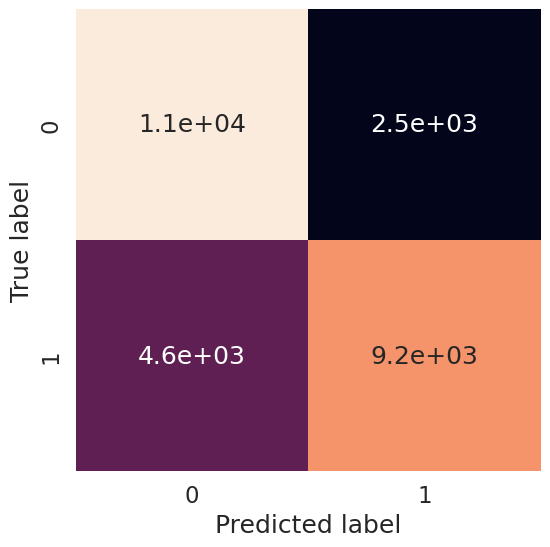

In [40]:
import matplotlib.ticker as ticker
sns.set_theme(font_scale=1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Plots a nice looking confusion matrix using Seaborn's heatmap().
    """
    matrix = confusion_matrix(y_test, y_preds)
    print(matrix)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax = sns.heatmap(
        matrix,
        annot=True, # Annotate the boxes
        cbar=False
    )
    plt.xlabel("Predicted label") # predictions go on the x-axis
    plt.ylabel("True label") # true labels go on the y-axis 

y_preds = model.predict(X_test)
plot_conf_mat(y_test, y_preds)

['no_churn_information' 17.58908404069558]
['transaction_date_month' 13.71383993444336]
['payment_method_id_39' 11.711086723790492]
['safra_month' 11.170324581749549]
['membership_expire_date_year' 5.69328010890544]
['membership_expire_date_day_of_year' 5.38430410156728]
['is_cancel' 3.6907078211319506]
['is_auto_renew' 3.5722950478487006]
['transaction_date_day_of_year' 2.3767852843814037]
['transaction_date_day' 1.689342776027317]
['registration_init_time_day_of_year' 1.5914083149580123]
['num_unq' 1.3018308845071054]
['membership_expire_date_month' 1.2095290033988535]
['registration_init_time_year' 1.1822974363255323]
['registration_init_time_day' 1.02295545539633]
['members_safra' 1.0119983861228339]
['plan_list_price' 0.9122486668582152]
['membership_expire_date_day' 0.8421149825696932]
['actual_amount_paid' 0.7447997638938931]
['registration_init_time_day_of_week' 0.6727834302776508]
['num_50' 0.6026075118398363]
['price_per_month' 0.5620912002340983]
['num_25' 0.540316388070474]

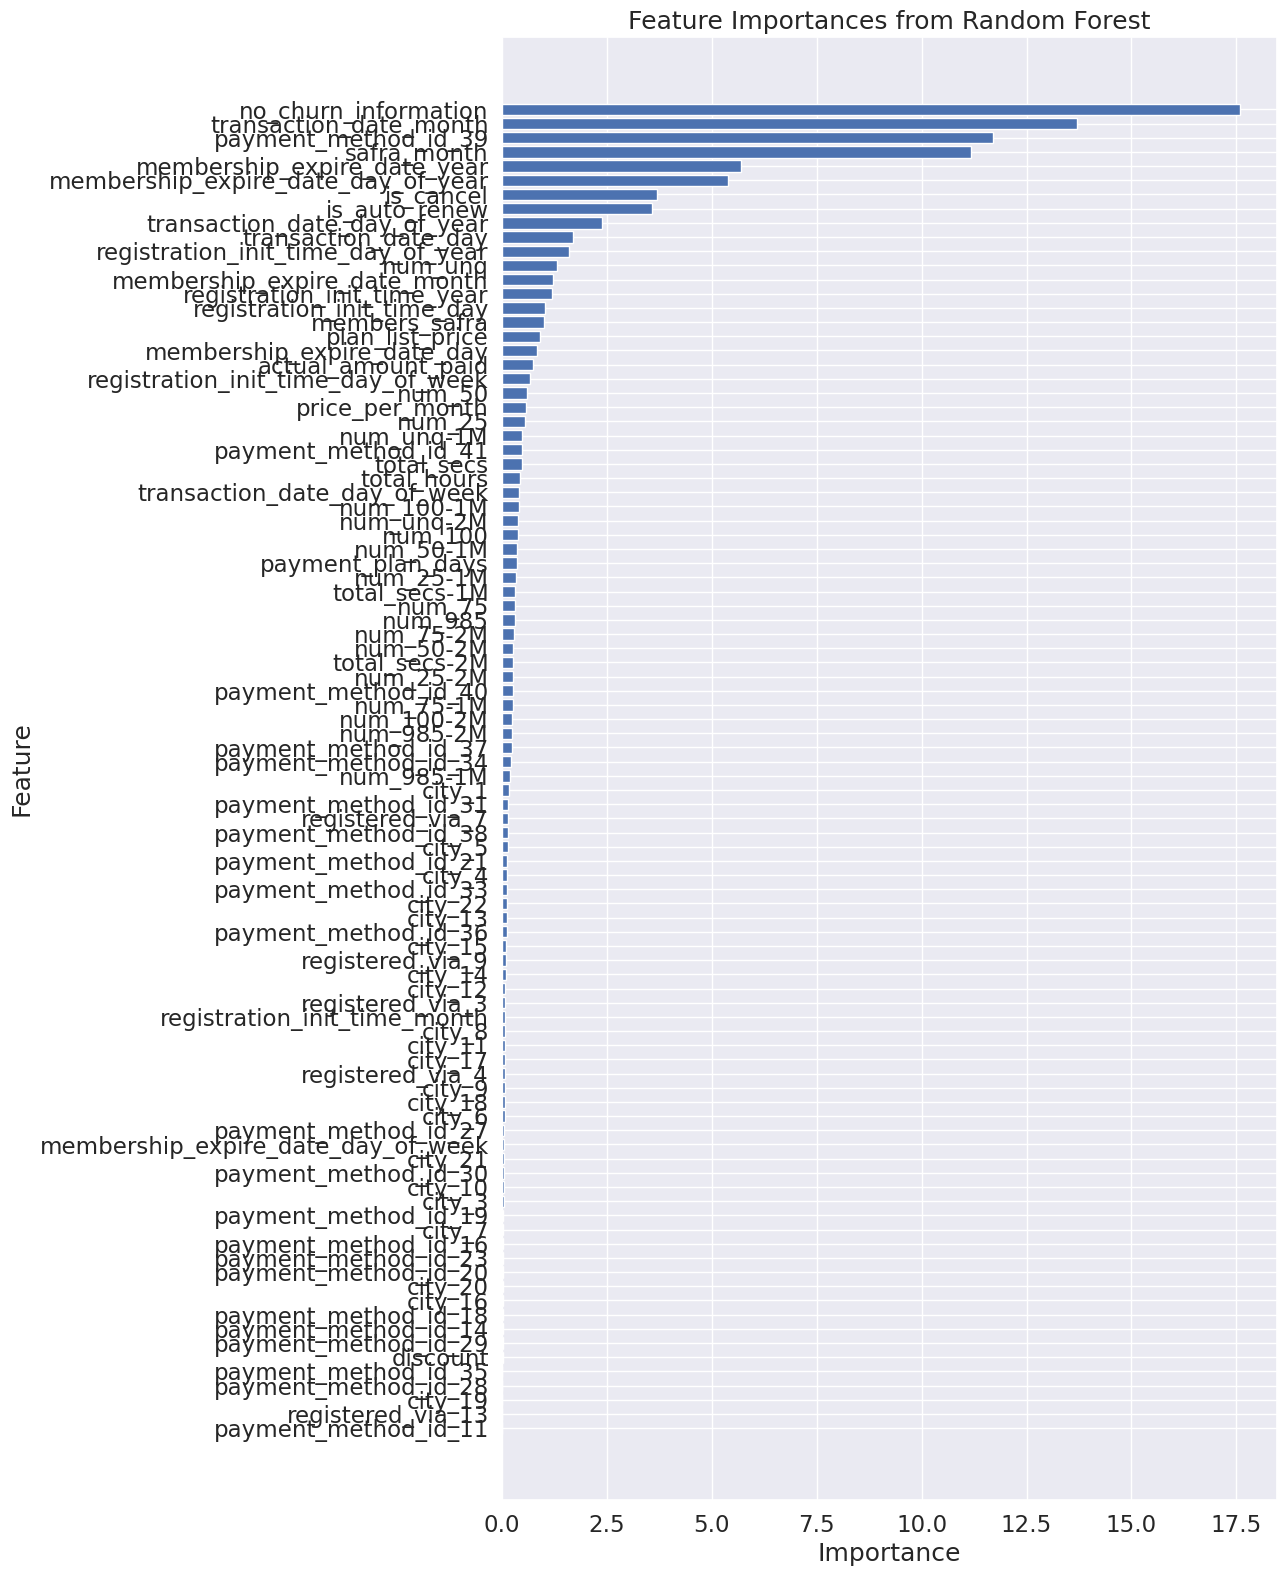

In [56]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# feature_importances = feature_importances[:50]

for f in feature_importances.values:
    print(f)


feature_importances = feature_importances[feature_importances['Importance'] >= 0.001]

# Plot the feature importances
plt.figure(figsize=(10, 19))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()